# Building a Convolutional Neural Net with Tensorflow

This tutorial demonstrates how to build a deep Convolutional Neural Network for image classification with Tensorflow using the 
[CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.html)

This notebook was created with the help of Udacity's template for their [Deep Learning](https://github.com/udacity/deep-learning/blob/master/image-classification/dlnd_image_classification.ipynb) course as well as 'deep-diver's [implementation of it](https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/blob/master/CIFAR10_image_classification.ipynb).

## 1. Getting Started

### Import Libraries

In [0]:
from __future__ import division
from __future__ import print_function

import argparse
import pickle
import numpy as np
import math
import random
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.utils import (saved_model_export_utils)
from tensorflow.python.keras.datasets import cifar10

tf.logging.set_verbosity(tf.logging.INFO)

### Get the data

In [2]:
"""Loads CIFAR10 dataset.
  Returns:
      Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
      Source: https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/datasets/cifar10.py
  """

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 38s 0us/step


### Explore and plot the data

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = 10

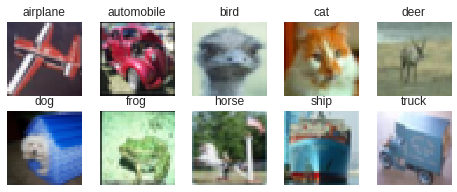

In [4]:
# Print figure with 10 random images from each
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(0,1,2))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

# 2. Create Model with TF Estimators

### Tensorflow APIs

Tensorflow is a hierarchical framework. The further down the hierarchy you go, the more flexibility you have, but that more code you have to write. A best practice is to start at the highest level of abstraction. Datasets and Estimators are two key TensorFlow higher level API's that are used a lot for ML projects:

- Datasets: Best practice way of creating input pipelines. 
- Estimators: A high-level API to create TensorFlow models. Estimators include canned models (out of the box) and custom estimators.

Below you see the TensorFlow architecture including the dataset API and Estimators. Combined, they offer an easy way to create TensorFlow models.

![title](https://3.bp.blogspot.com/-l2UT45WGdyw/Wbe7au1nfwI/AAAAAAAAD1I/GeQcQUUWezIiaFFRCiMILlX2EYdG49C0wCLcBGAs/s1600/image6.png)

For this tutorial we will be operating at the highest level of Tensorflow abstraction, using the Estimator API.

### Preprocess Functions

In [0]:
# Min-Max Normalization simply makes all x values to range between 0 and 1.
# y = (x-min) / (max-min)

def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [0]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

### Preprocess all the data and save it

The code cell below uses the previously implemented functions, normalize and one_hot_encode, to preprocess the given dataset. Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [0]:
def _preprocess_and_save(features, labels, filename):
    # - normalize the features
    # - one_hot_encode the lables
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

def preprocess_and_save_data(x_train, y_train, x_test, y_test):
    x_batch = {}
    y_batch = {}
    for i in range(5):
        x_batch[i] = x_train[10000*i:10000*(i+1),:]
        y_batch[i] = y_train[10000*i:10000*(i+1),:]
    
    #x_batch = tf.split(x_train, num_or_size_splits=5, axis=0)
    #y_batch = tf.split(y_train, num_or_size_splits=5, axis=0)
    valid_features = []
    valid_labels = []
    
    for i in range(len(x_batch)):
        features, labels = x_batch[i], y_batch[i]
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features)*0.1)
        
        # preprocess the 90% of the whole dataset of the batch
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(
            features[:-index_of_validation],
            labels[:-index_of_validation],
            'preprocess_batch_' + str(i+1) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(
      np.array(valid_features),
      np.array(valid_labels),
      'preprocess_validation.p')

    # Preprocess and Save all testing data
    _preprocess_and_save(
      np.array(x_test),
      np.array(y_test),
      'preprocess_testing.p')

In [0]:
preprocess_and_save_data(x_train, y_train, x_test, y_test)

## Checkpoint

This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [0]:
# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the Network

The image below depicts what the model would look like in this notebook.

![title](https://raw.githubusercontent.com/deep-diver/CIFAR10-img-classification-tensorflow/master/conv_model.png)

### Prepare Input for the Model
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability.

#### Some references to look up
- [Tensorflow Data Type](https://www.tensorflow.org/api_docs/python/tf/DType)
- [Tensorflow Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
- [Tensorflow Variable](https://www.tensorflow.org/api_docs/python/tf/Variable)

In [0]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y = tf.placeholder(tf.int32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Create Convolutional Model

The entire model consists of 14 layers in total. In addition to layers below lists what techniques are applied to build the model.

1. Convolution with 64 different filters in size of (3x3)
2. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
3. Convolution with 128 different filters in size of (3x3)
4. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
5. Convolution with 256 different filters in size of (3x3)
6. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
7. Convolution with 512 different filters in size of (3x3)
8. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
9. Flattening the 3-D output of the last convolutional operations.
10. Fully Connected Layer with 128 units
  - Dropout 
  - Batch Normalization
11. Fully Connected Layer with 256 units
  - Dropout 
  - Batch Normalization
12. Fully Connected Layer with 512 units
  - Dropout 
  - Batch Normalization
13. Fully Connected Layer with 1024 units
  - Dropout 
  - Batch Normalization
14. Fully Connected Layer with 10 units (number of image classes)

In [0]:
def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    output = tf.contrib.layers.fully_connected(inputs=full4, num_outputs=10, activation_fn=None)
    return output

## Build the Neural Network

### Hyperparameters

* `epochs`: number of iterations until the network stops learning or start overfitting
* `batch_size`: highest number that your machine has memory for.  Most people set them to common sizes of memory:
* `keep_probability`: probability of keeping a node using dropout
* `learning_rate`: number how fast the model learns

In [0]:
epochs = 3
batch_size = 64
keep_probability = 0.7
learning_rate = 0.001

### Cost Function & Optimizer

- [Tensorflow Softmax Cross Entropy with Logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2)
- [Tensorflow Reduce Mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)
- [Tensorflow Optimizers](https://www.tensorflow.org/api_guides/python/train)
- [Tensorflow Equal](https://www.tensorflow.org/api_docs/python/tf/equal)
- [Tensorflow Cast](https://www.tensorflow.org/api_docs/python/tf/cast)
- [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/)
- [Optimization for Training Deep Models](http://www.deeplearningbook.org/contents/optimization.html)

In [13]:
logits = conv_net(x, keep_prob)
model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Train the Neural Network

We have defined cost, optimizer and accuracy, and what they really are is..
- **cost**:  
   - tf.reduce_mean returns => The reduced **Tensor**
- **optimizer**:  
   - tf.train.AdamOptimizer returns => An **Operation** that applies the specified gradients.
- **accuracy**: 
   - tf.reduce_mean returns => The reduced **Tensor**

tf.Session.run method in the official document explains it runs one "step" of TensorFlow computation, by running the necessary graph fragment to execute every Operation and evaluate every Tensor in fetches, substituting the values in feed_dict for the corresponding input values. The fetches argument may be a single graph element, or an arbitrarily nested list, tuple, etc.

Here what graph element really is tf.Tensor or tf.Operation. Cost, Optimizer, and Accuracy are one of those types meaning they can be specified as part of the fetches argument. Then, we can feed some variables along the way. This is kind of handy feature of Tensorflow. Once we have constructed the graph, all we need to do is feeding data into that graph and specifying what results to retrieve.



#### some references to look up
- [Tensorflow Session run function](https://www.tensorflow.org/api_docs/python/tf/Session#run)
- [Tensorflow tf.reduce_mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)
- [Tensorflow tf.train.AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)


### Single Optimization

Implement the function train_neural_network to do a single optimization. The optimization should use optimizer to optimize in session with a feed_dict of the following:

- x for image input
- y for labels
- keep_prob for keep probability for dropout

This function will be called for each batch, so tf.global_variables_initializer() has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [0]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

### Show Stats

Implement the function print_stats to print loss and validation accuracy. Use the global variables valid_features and valid_labels to calculate validation accuracy. Use a keep probability of 1.0 to calculate the loss and validation accuracy.

In [0]:
def print_stats(session, feature_batch, label_batch, valid_features, valid_labels, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

### Helper Functions for Training

In [0]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy. Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [0]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
  # Measures total program runtime by collecting start time
  start_time = time()
    
  # Initializing the variables
  sess.run(tf.global_variables_initializer())

  # Training cycle
  for epoch in range(epochs):
      batch_i = 1
      for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
          train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
      print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
      print_stats(sess, batch_features, batch_labels, valid_features, valid_labels, cost, accuracy)

  # Measure total program runtime by collecting end time
  end_time = time()

  # Computes overall runtime in seconds & prints it in hh:mm:ss format
  tot_time = end_time - start_time
  print("\n** Total Elapsed Runtime:",
        str(int((tot_time/3600)))+":"+str(int((tot_time%3600)/60))+":"
        +str(int((tot_time%3600)%60)) )

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

NOTE: This includes a checkpoint. The model has been saved to disk afterwards.

In [0]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
  # Measures total program runtime by collecting start time
  start_time = time()

  # Initializing the variables
  sess.run(tf.global_variables_initializer())
    
  # Training cycle
  for epoch in range(epochs):
      # Loop over all batches
      n_batches = 5
      for batch_i in range(1, n_batches + 1):
          for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
              train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
          print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
          print_stats(sess, batch_features, batch_labels, valid_features, valid_labels, cost, accuracy)
            
  # Save Model
  saver = tf.train.Saver()
  save_path = saver.save(sess, save_model_path)

  # Measure total program runtime by collecting end time
  end_time = time()

  # Computes overall runtime in seconds & prints it in hh:mm:ss format
  tot_time = end_time - start_time
  print("\n** Total Elapsed Runtime:",
        str(int((tot_time/3600)))+":"+str(int((tot_time%3600)/60))+":"
        +str(int((tot_time%3600)%60)) )

### Setting up Tensorboard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

## Test your Model

In [0]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()